## Credit Card Fraud Detection
<p align="center">
  <img src="images/credit-card-fraud-banner.jpg" alt="banner-credit-card" height="300px">
</p>
<div style="text-align: right; margin-left: auto; margin-right: auto; width: 450px;">
  <a href="http://www.freepik.com">Designed by starline / Freepik</a>
</div>

Credit card fraud remains a growing threat, costing businesses and consumers billions of dollars annually. In recent years, as digital transactions have surged, so too have the number of fraud attempts. According to industry reports, the global financial losses due to payment card fraud have reached staggering figures, with estimates exceeding $32 billion in 2023 alone.

Fraudsters are constantly evolving their tactics, making it more challenging to detect suspicious activities. However, with advances in machine learning and data analytics, businesses have new tools to combat fraud effectively. By training models on historical transaction data, we can identify patterns indicative of fraudulent behavior, thus minimizing the risk and impact.

To be less susceptible to fraud, consumers and businesses alike need to adopt multi-layered security measures, such as two-factor authentication, real-time transaction monitoring, and leveraging artificial intelligence to detect anomalies.

In this notebook, we will explore the use of machine learning to detect fraudulent credit card transactions using a dataset provided by Kaggle. The model developed here aims to showcase how modern algorithms can be applied to identify potentially fraudulent activities in a dataset with highly imbalanced classes—where legitimate transactions vastly outnumber fraudulent ones.

Our goal is to present actionable insights that can help decision-makers in reducing fraud rates and safeguarding financial assets.

### Data Acquistion

#### 1 - Import packages and initial configuration
Packages that will be used in this notebook and initial configuration of the notebook.
- `pandas` - data manipulation
- `numpy` - general manipulation of arrays
- `matplotlib` and `seaborn`- data visualization  
-  

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

np.random.seed(7)
pd.set_option("display.max_columns", None)
sns.set_theme()
%matplotlib inline

#### 2 - Get familiar to the dataset

In [2]:
# dataset path
DATA_PATH = "datasets\\creditcard.csv"

# import the dataset to a dataframe
df = pd.read_csv(DATA_PATH)

# dataset size and show firsts 5 inputs
print(f"""Dataset size: \tSamples: {df.shape[0]}
      \t\tFeatures: {df.shape[1]}""")
df.head()

Dataset size: 	Samples: 284807
      		Features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This dataset presents transactions that occurred in two day and it contains almost 285,000 samples and 31 features. 
According to Kaggle, due to confidentiality issues, it is not allowed to provide the original features. Hence the dataset contains only numeric input variables which are the result of a PCA transformation. Principal Component Analysis (PCA) is a powerful unsupervised machine learning technique used for dimensionality reduction and feature extraction. It aims to find the principal components, which are new uncorrelated variables that capture the maximum variance in the data.

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

##### 2.1 - Variables dictionary
- `Time`: contains the seconds elapsed between the respective transaction of the sample and the first transaction in the dataset
- `V1, V2, ..., V28`: contain the numerical values obtained from the PCA transformation
- `Amount`: contains the amount for each transaction sample
- `Class`: categorical variable that takes the value 1 for a fraudulent transaction and 0 for a valid transaction.

### Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a critical step in the data science process. It involves investigating the dataset to uncover patterns, detect anomalies, and check assumptions through visual and statistical methods. EDA helps in understanding the structure and quality of the data before applying machine learning models, ensuring that potential issues such as missing values, outliers, or skewed distributions are addressed.

In this section, we will perform a series of initial analyses to get a better understanding of the dataset. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Using the info() and isnull() methods, we can confirm that there are no missing values. Additionally, except for the Class feature, which is *int* type, all other features contain float values. The `time`, `amount`, and `Class` variables are the only ones that have not been transformed by PCA.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Using the **describe()** method, we observe that there are no discrepant values related to the PCA transformation.
the mean transaction value is 88.34, the median is 22.00, and the maximum value is 25,691.16. The significant difference between the mean and median suggests the presence of high-value outliers.
Finally, as expected for the Class variable, the maximum value is 1, indicating a fraudulent transaction.

In [6]:
valid_transaction = df["Class"].value_counts()[0]
fraud_transaction = df["Class"].value_counts()[1]
print(f"Valid transactions: \t {valid_transaction} -> {(valid_transaction/df.shape[0]*100):.3f}%")
print(f"Fraudulent transactions: {fraud_transaction}    -> {(fraud_transaction/df.shape[0]*100):.3f}%")

Valid transactions: 	 284315 -> 99.827%
Fraudulent transactions: 492    -> 0.173%


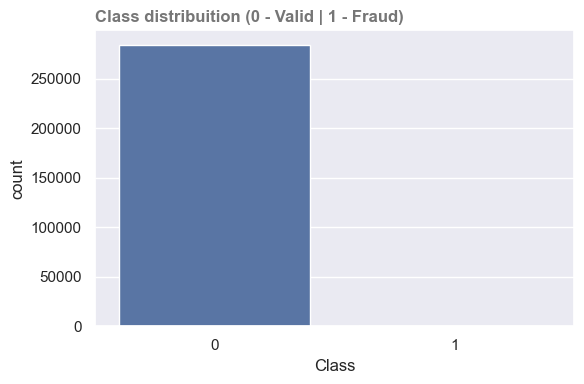

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x=df["Class"], ax=ax)
ax.set_title("Class distribuition (0 - Valid | 1 - Fraud)", fontsize=12, fontweight="bold", color="#767676",loc="left")
plt.tight_layout()

As mentioned above, the dataset is highly imbalanced, related to the target variable Class type (indicating valid or fraudulent transaction). This imbalance is expected, as in real-world credit card usage, valid transactions far exceed fraudulent ones. In this dataset, valid transactions account for 99.827% of the samples, while fraudulent transactions represent only 0.173%.

This imbalance can negatively affect the performance of the machine learning model. Therefore, before training the model, it will be necessary to balance the dataset to build a non-biased model.

By using the two features that were not subjected to the PCA transformation, we can observe the frequency of these features over the 48-hour period.

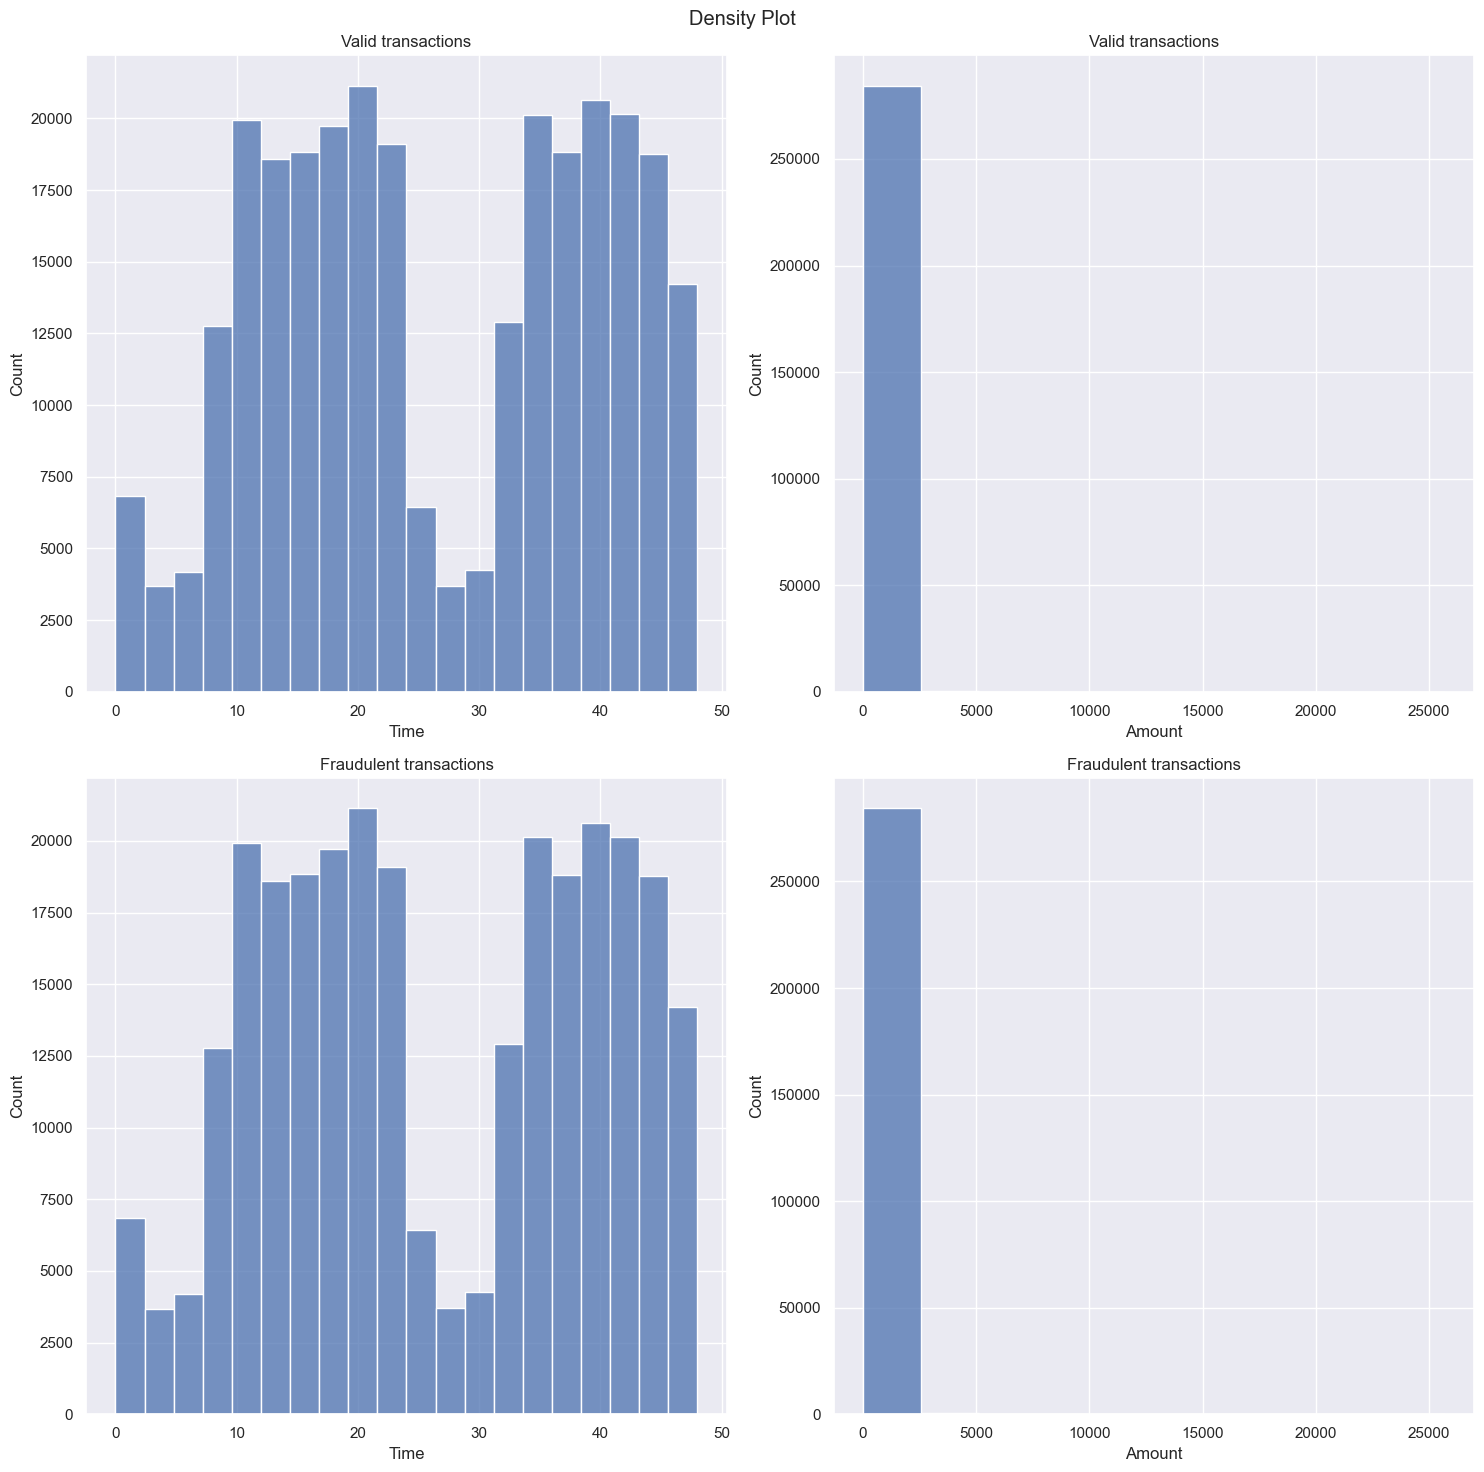

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
sns.histplot(data=df[df["Class"]==0], x=df["Time"]/3600, bins=20, ax=ax1)
sns.histplot(data=df[df["Class"]==1], x=df["Time"]/3600, bins=20, ax=ax3)
sns.histplot(data=df[df["Class"]==0], x=df["Amount"], bins=10, ax=ax2)
sns.histplot(data=df[df["Class"]==1], x=df["Amount"], bins=10, ax=ax4)

fig.suptitle("Density Plot")
ax1.set_title("Valid transactions")
ax3.set_title("Fraudulent transactions")
ax2.set_title("Valid transactions")
ax4.set_title("Fraudulent transactions")



plt.tight_layout()  # Adjust spacing between subplots 
plt.show()


When comparing the histograms of valid and fraudulent transactions for the ``Time`` and ``Amount`` features, there is no significant difference that could assist the machine learning model in classifying the transactions. Additionally, it is highly likely that there are outliers in the ``Amount`` feature. Therefore, boxplots will now be plotted to check for any potential differences.

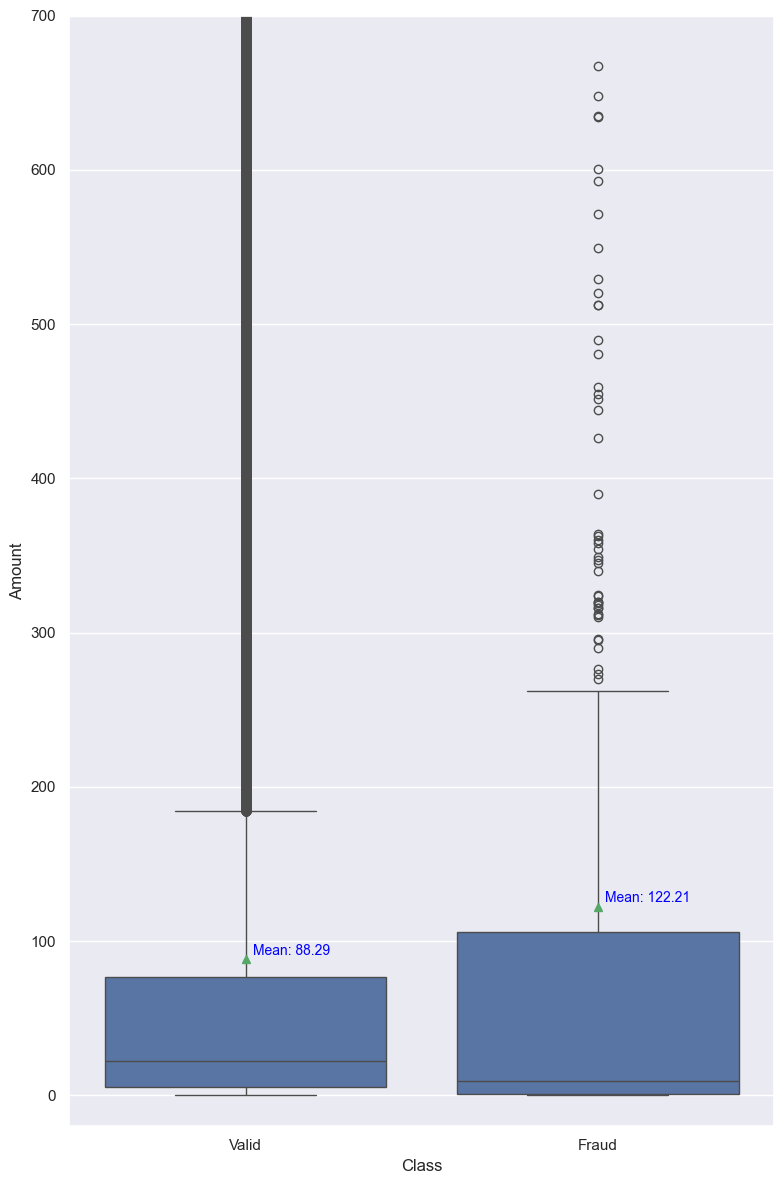

In [9]:
fig, ax = plt.subplots(figsize=(8,12), sharex=True)
sns.boxplot(data=df, x=df["Class"], y=df["Amount"], showmeans=True, ax=ax)
plt.ylim((-20,700))
plt.xticks([0,1],["Valid", "Fraud"])

mean_valid = df.groupby(by="Class")["Amount"].mean()[0]
mean_fraud = df.groupby(by="Class")["Amount"].mean()[1]

# Add mean values as text annotations
ax.text(ax.get_xticks()[0]+0.02, mean_valid + 1, f"Mean: {mean_valid:.2f}", ha='left', va='bottom', fontsize=10, color='blue')
ax.text(ax.get_xticks()[1]+0.02, mean_fraud + 1, f"Mean: {mean_fraud:.2f}", ha='left', va='bottom', fontsize=10, color='blue')

plt.tight_layout()





The boxplots reveal a noticeable difference between fraudulent and valid transactions, and confirms the existence of outliers. Additionally, the mean value for fraudulent transactions is higher than that for valid transactions. This difference could contribute to improving the performance of the machine learning model during training.

Another visualization that helps understand which features are the most important to detect the fraudulents transaction is the density plot. In the density plot we look for difference between the types of transaction.

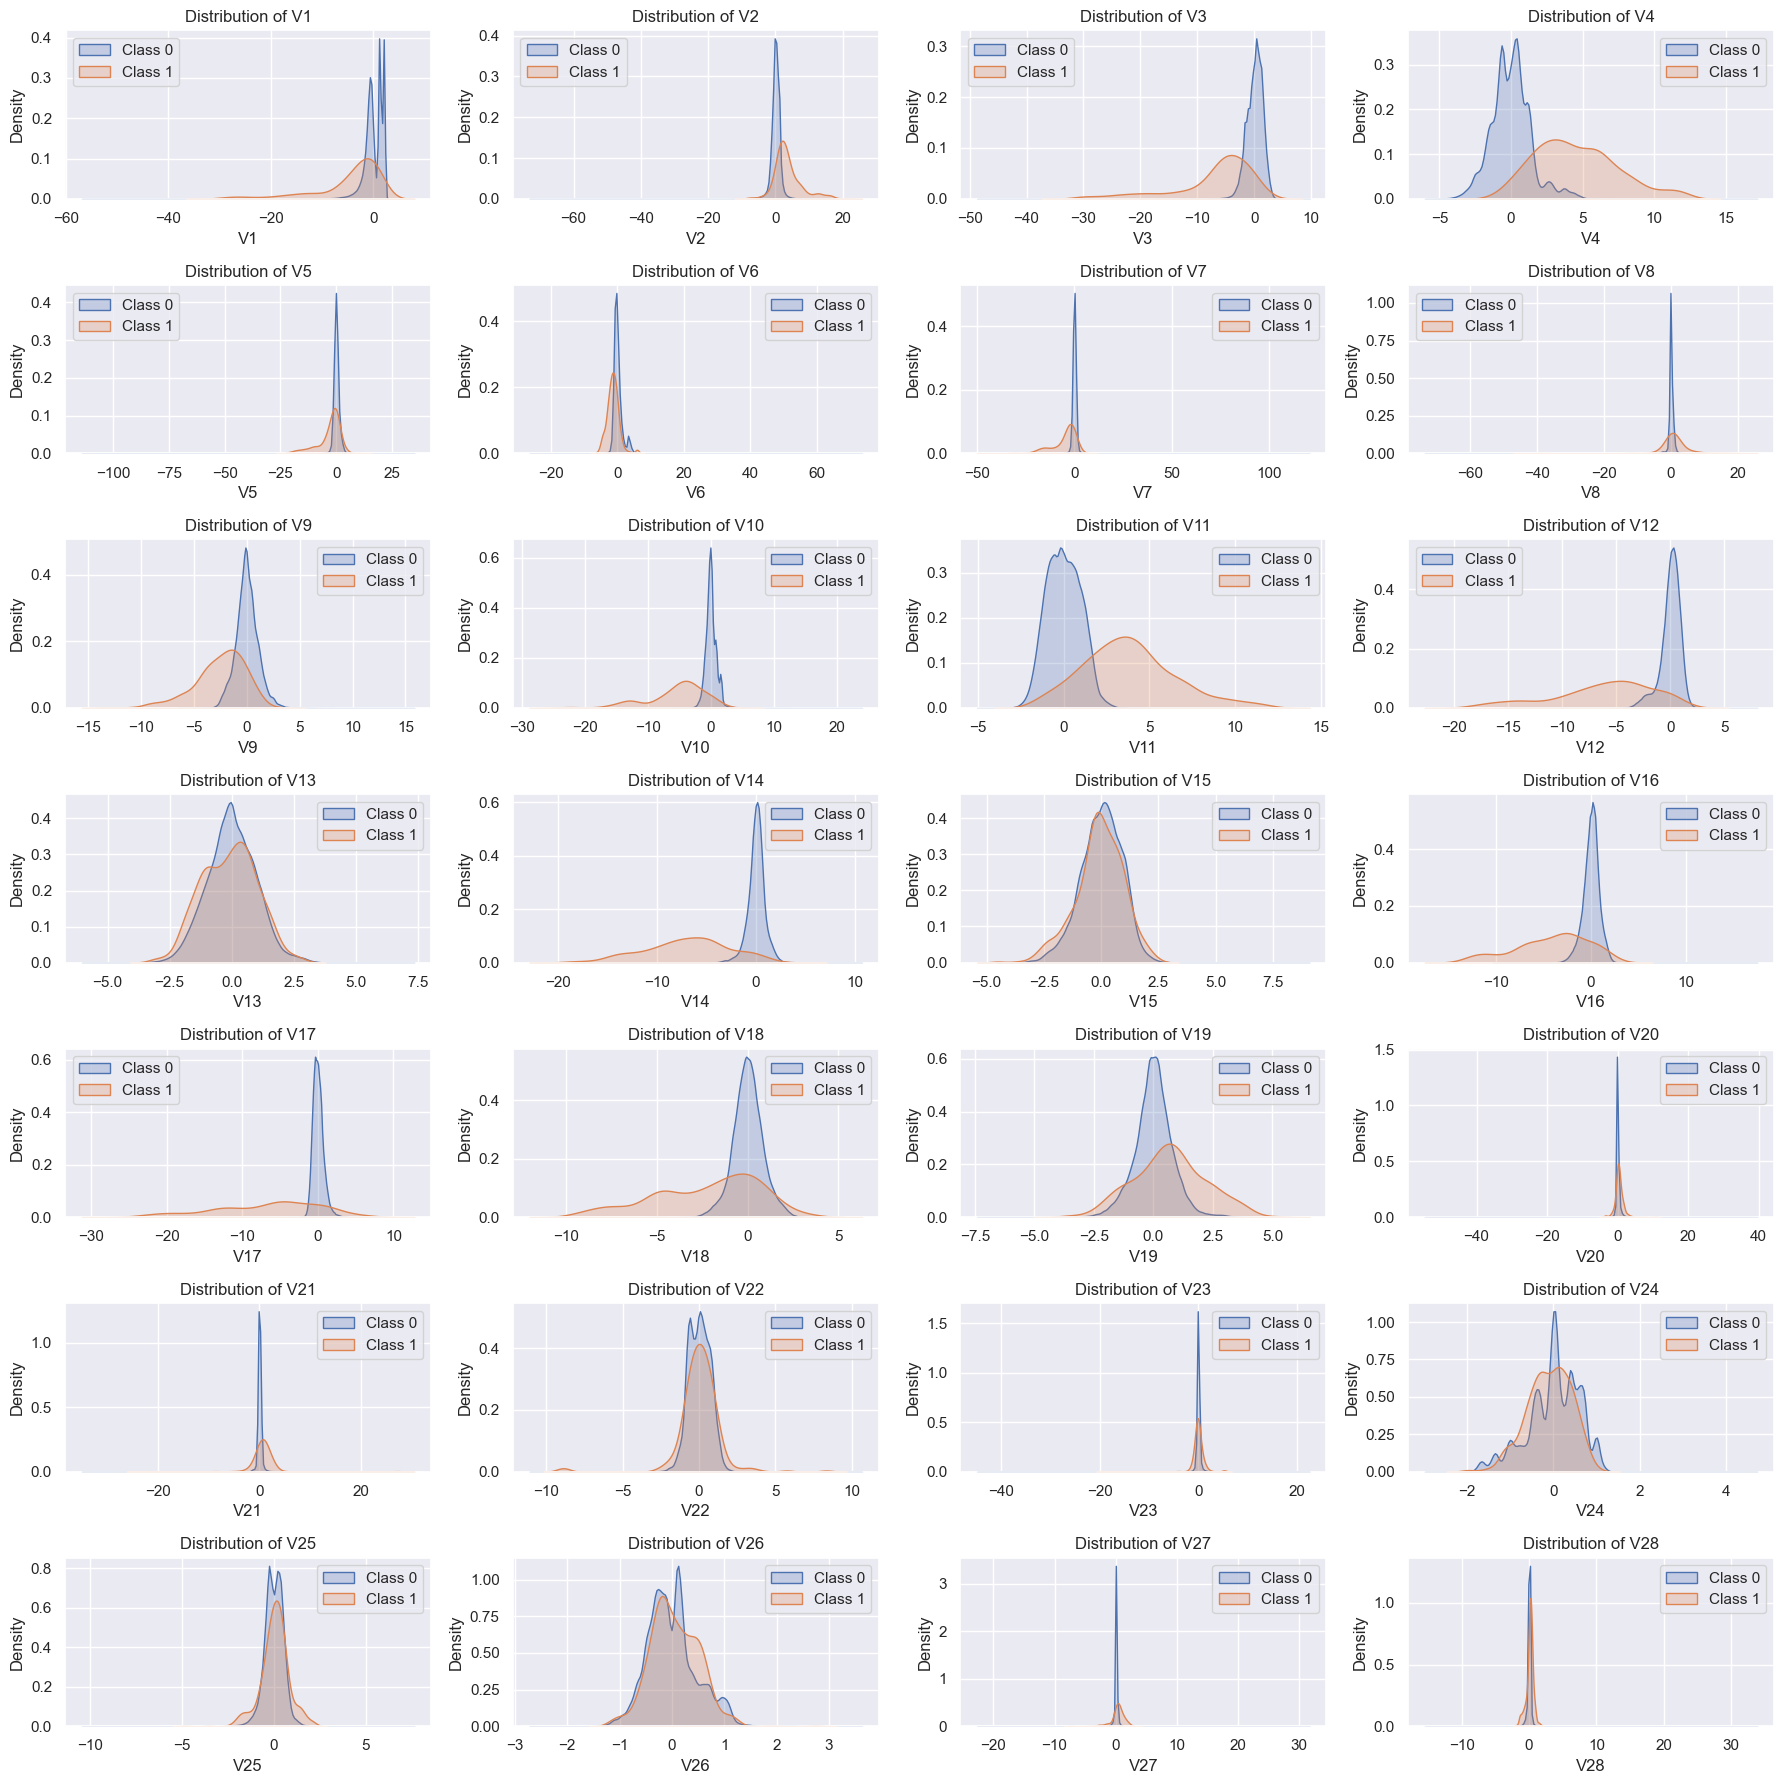

In [10]:
pda_features = df.drop(["Time", "Amount", "Class"], axis=1).columns

fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(18, 18))

axes = axes.flatten()

for idx, feature in enumerate(pda_features):
    sns.kdeplot(data=df[df["Class"]==0], x=feature, fill=True, label="Class 0", ax=axes[idx])
    sns.kdeplot(data=df[df["Class"]==1], x=feature, fill=True, label="Class 1", ax=axes[idx])
    axes[idx].set_title(f"Distribution of {feature}")
    axes[idx].legend()

plt.tight_layout()



These density plots reveal that certain variables may be highly important for training the machine learning model, as they exhibit different distributions between valid and fraudulent transactions. This is the case for features such as V3, V4, V10, V11, V12, V14, V16, V17. On the other hand, some features, like V13, V15, V22, V25, V26, V28, likely won't be as important, since their distributions are very similar for both types of transactions.

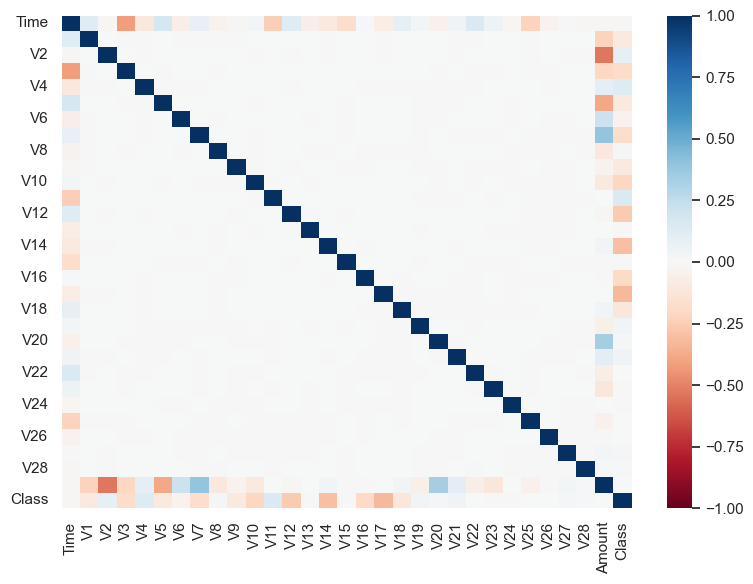

In [11]:
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(data=df_corr, cmap="RdBu", vmin=-1)

plt.tight_layout()

In summary, the Exploratory Data Analysis (EDA) has shown the following:

- The dataset is highly imbalanced, with valid transactions representing 99.827% and fraudulent transactions only 0.173% of the data.
- There are no missing values, but outliers are present.
- All feature values are composed of float values.
- It will be necessary to standardize the Time and Amount variables.
- The correlation between variables is low.
- The density plots revealed that some variables have very similar distributions, while others have distinct distributions, which could contribute to model training."


### Data pre-processing

#### 1 - Standardize

In the world of machine learning, not all data is created equal. Features with vastly different scales can introduce bias and hinder the performance of many algorithms. That's where standardization, a powerful preprocessing technique, comes to the rescue.

**Why Standardize?**

Imagine training a model to predict house prices. You have features like "number of bedrooms" (ranging from 1 to 5) and "house area in square feet" (ranging from 800 to 5000). The large difference in scales can mislead some algorithms, making them prioritize the "house area" feature simply because its values are numerically larger.

Standardization levels the playing field by transforming each feature to have:
- Mean (average) of 0
- Standard deviation of 1

This ensures that all features contribute equally to the model's learning process, regardless of their original scales.

**How it Works:**

Standardization, also known as Z-score normalization, follows a simple yet effective formula:

*z = (x - mean) / standard deviation*

Where:
- z is the standardized value
- x is the original value
- mean is the average of the feature
- standard deviation measures the spread or variability of the feature

**Benefits:**

- Improved Model Performance: By mitigating the impact of scale differences, standardization can lead to faster model training and more accurate predictions, particularly for algorithms like K-Nearest Neighbors, Support Vector Machines, and those using regularization techniques.
- Reduced Bias: Standardization helps prevent features with larger ranges from disproportionately influencing the model, ensuring fairness in feature importance.

In the code cell below, we'll use scikit-learn's method StandardScaler to perform standardization on `Time` and `Amount` variables.

In [12]:
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean["std_time"] = std_scaler.fit_transform(df_clean["Time"].values.reshape(-1,1))
df_clean["std_amount"] = std_scaler.fit_transform(df_clean["Amount"].values.reshape(-1,1))

df_clean.drop(["Time", "Amount"], axis=1, inplace=True)

df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_time,std_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.996562,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.996562,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.996541,-0.073403


#### 2 - Dataset Splitting: Training, Validation, and Test Sets

In [13]:
# dataset for test
test = df_clean.sample(frac=0.15, random_state=0)

# remove the test data from the original dataset
df_clean = df_clean.drop(test.index)

print("Test dataset dimension:", test.shape)
print("Training/validation dataset dimension:", df_clean.shape)
print("Original dataset dimension:", df.shape)


Test dataset dimension: (42721, 31)
Training/validation dataset dimension: (242086, 31)
Original dataset dimension: (284807, 31)


In [14]:
# dataset for training and validation and target variable y
X = df_clean.drop("Class", axis=1)
y = df_clean["Class"]

# Splitting the dataset into training and validation datasets
# stratify = y -> ensures that the class distribution in your original dataset (y) is proportionally maintained in both the training and validation sets.
# shuffle = True -> helps prevent potential biases that might arise if your data has some inherent order
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, shuffle=True)

#### 3 - Balancing the dataset

Class
0    313
1    313
Name: count, dtype: int64

Dimension before balancing: (181564,)
Dimension after balancing: (626,)


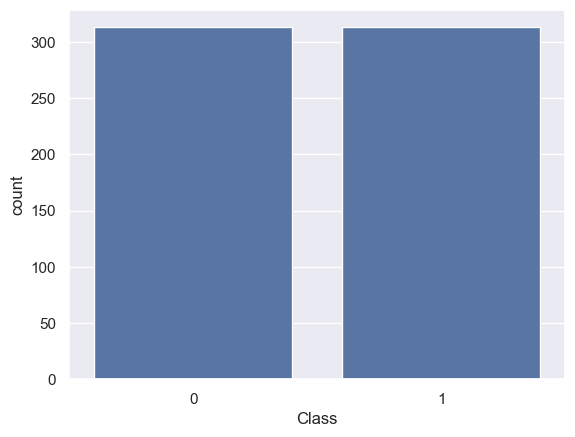

In [15]:
# using under-sampling technique
rus = RandomUnderSampler()
X_rus, y_rus, = rus.fit_resample(X_train, y_train)

# verifying the balance
print(pd.Series(y_rus).value_counts())

fig, ax = plt.subplots()
sns.countplot(x=y_rus, ax=ax)

print("\nDimension before balancing:", y_train.shape)
print("Dimension after balancing:", y_rus.shape)

#### 4 - Correlation Matrix after balancing

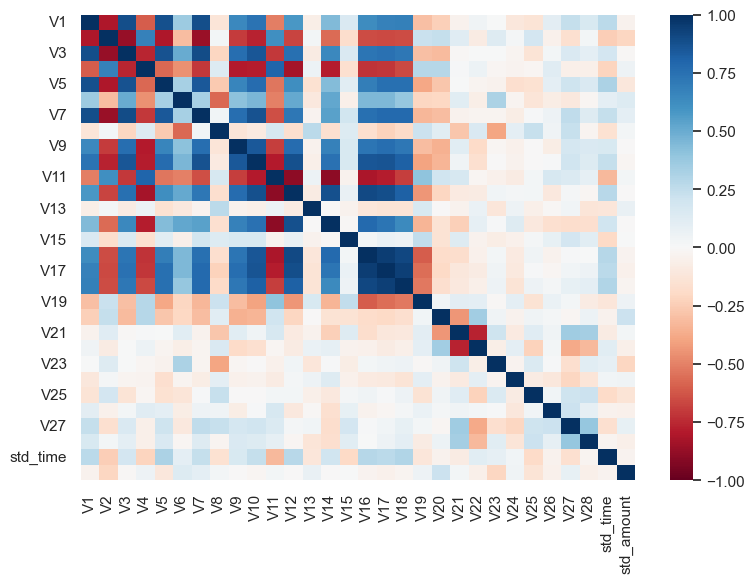

In [16]:
df_corr_rus = X_rus.corr()

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(data=df_corr_rus,cmap="RdBu", vmin=-1)
plt.tight_layout()

### Machine Learning Models
After understanding the data, standardizing the features, splitting the dataset into training, validation, and test sets, identifying the target variable, and balancing the dataset, it is now ready for model training. Since we are interested in classifying transactions as fraud or non-fraud, we will explore several classification models, including Logistic Regression, Decision Tree, K-Nearest Neighbors, and Random Forest Classifier. We will use a supervised learning approach, where the model will learn from the labeled training data to predict new transactions.

The performance of each machine learning model will be evaluated using the validation dataset. After identifying the model with the best performance, we will use the test dataset for the final evaluation to confirm its effectiveness.

#### 1 - Logistic Regression
Logistic Regression is a powerful algorithm for classification tasks, making it perfect for our goal of labeling credit card transactions as fraudulent or legitimate.

Here's a breakdown:

**1. What it does:**

Unlike linear regression which predicts continuous values, Logistic Regression predicts the probability of an instance belonging to a specific class. In our case, it estimates the likelihood of a transaction being fraudulent.

It achieves this by fitting a sigmoid function to the data, which always outputs a value between 0 and 1, representing the probability.

A predefined threshold (usually 0.5) is then used to classify the transaction:

Probability > threshold = Fraudulent

Probability <= threshold = Legitimate

**2. Why it's suitable for our project:**

Interpretability: Logistic Regression provides insights into the importance of different features in predicting fraud, allowing us to understand the factors driving the model's decisions. This is crucial for explaining our model's behavior and building trust in its predictions.

Efficiency: It's computationally less expensive compared to more complex algorithms, making it suitable for large datasets like ours and enabling faster training and prediction times.

Good Baseline: Logistic Regression often serves as a strong baseline model for classification tasks. It helps us gauge the performance of more complex models and understand if their added complexity is justified by improved accuracy.

**3. Limitations to consider:**

Assumptions: Logistic Regression assumes a linear relationship between the features and the log-odds of the target variable. While this assumption might not always hold true in complex datasets, feature engineering techniques can help address this limitation.

Sensitivity to outliers: Similar to linear regression, outliers can significantly influence the model's performance. Therefore, robust preprocessing steps like outlier detection and treatment are crucial.

**Moving forward:**

In the following sections, we'll delve into the implementation of Logistic Regression for our credit card fraud detection project. We will evaluate the model using appropriate metrics like precision, recall, and F1-score, and interpret the results to gain valuable insights from our model.

In [17]:
# defining and training the LR model
model_lr = LogisticRegression()
model_lr.fit(X_rus, y_rus)

# forecast using validation dataset
y_pred_lr = model_lr.predict(X_val)
y_prob_lr = model_lr.predict_proba(X_val)

print("y_pred_lr: ", y_pred_lr[:30])
print("\ny_prob_lr:\n", y_prob_lr[:30])

y_pred_lr:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

y_prob_lr:
 [[0.86396629 0.13603371]
 [0.99056412 0.00943588]
 [0.78564677 0.21435323]
 [0.99100516 0.00899484]
 [0.887588   0.112412  ]
 [0.99815448 0.00184552]
 [0.97714905 0.02285095]
 [0.97857747 0.02142253]
 [0.96287659 0.03712341]
 [0.98036748 0.01963252]
 [0.98695386 0.01304614]
 [0.8683627  0.1316373 ]
 [0.23337081 0.76662919]
 [0.99156446 0.00843554]
 [0.78808551 0.21191449]
 [0.94548842 0.05451158]
 [0.99862965 0.00137035]
 [0.95479815 0.04520185]
 [0.98002852 0.01997148]
 [0.96947862 0.03052138]
 [0.87833894 0.12166106]
 [0.97445343 0.02554657]
 [0.97525765 0.02474235]
 [0.93765068 0.06234932]
 [0.93718617 0.06281383]
 [0.92966701 0.07033299]
 [0.93010799 0.06989201]
 [0.98072799 0.01927201]
 [0.94372481 0.05627519]
 [0.9098658  0.0901342 ]]


The `predict` method allows us to classify each transaction, where 0 represents a valid transaction and 1 represents a fraudulent one. Additionally, the `predict_proba` method provides the probability of a transaction being classified as valid (first element) or fraudulent (second element).

Classification report:
               precision    recall  f1-score   support

           0     0.9998    0.9721    0.9858     60417
           1     0.0533    0.9048    0.1007       105

    accuracy                         0.9720     60522
   macro avg     0.5266    0.9384    0.5433     60522
weighted avg     0.9982    0.9720    0.9842     60522

Accuracy: 0.9720
AUC: 0.9384



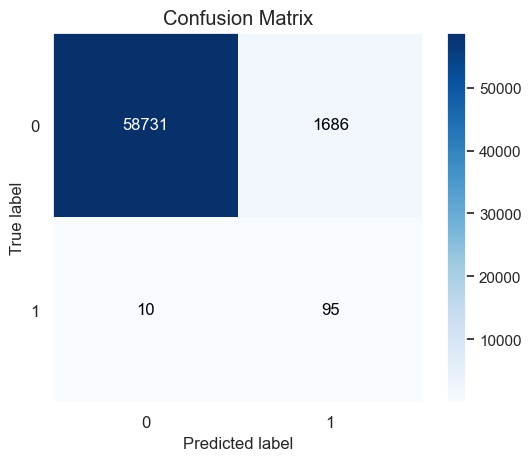

In [18]:
# confusion matrix plot
skplt.metrics.plot_confusion_matrix(y_val, y_pred_lr)

# Classification report
print("Classification report:\n", classification_report(y_val, y_pred_lr, digits=4))

# Accuracy and area under the curve
print(f"Accuracy: {accuracy_score(y_val, y_pred_lr):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_pred_lr):.4f}\n")
plt.show()



The Confusion Matrix provides a clear view of the model’s performance by comparing true values with predicted values. In this validation dataset, there are 60,417 valid transactions (58731 + 1686) and 105 fraudulent transactions (10 + 95).

Regarding the true values, among the total valid transactions, 58,731 were correctly predicted (97.21%), while 1686 were incorrectly predicted as fraudulent (2.79%). For the fraudulent transactions, 95 were correctly predicted (90.48%) and 10 were incorrectly classified as valid (9.52%).

When looking at the predicted values, of the total predicted fraudulent transactions (95 + 1686 = 1781), 95 were correct (5.33%), and 1686 were incorrect (94.67%). For predicted valid transactions (58731 + 10 = 58741), 58731 were correct (99.98%), and 10 were incorrect (0.02%).

The model achieved an overall accuracy of 97.20%, indicating that 97.20% of all predictions, both fraud and non-fraud, were correct. Additionally, the AUC (Area Under the Curve) was 93.84%.



#### 2 - Decision Tree

Moving beyond linear models, we introduce Decision Trees, a powerful machine learning algorithm known for its intuitive and transparent approach to classification. Just as its name suggests, this algorithm mimics human decision-making by constructing a tree-like structure to classify credit card transactions.

Here's how it works:

**1. Building the Tree:**

Root Node: The algorithm begins by considering the entire dataset and selecting the "best" feature that splits the data into subsets most effectively, separating fraudulent transactions from legitimate ones.

Branching Out: Each subset then becomes a child node, and the process repeats recursively. The algorithm searches for the most informative feature to further partition the data, creating branches in the tree.

Leaf Nodes (Decisions): This process continues until a predefined stopping criterion is met, such as reaching a maximum depth or a minimum number of samples per leaf. Each leaf node represents a final decision point, classifying a transaction as either fraudulent or legitimate.

**2. Why Decision Trees are a good fit:**

Interpretability: Decision Trees provide a highly interpretable model. We can easily visualize the decision-making process by following the branches of the tree and understanding the factors that led to each classification. This transparency is valuable for understanding the model's behavior and building trust with stakeholders.

Handling Non-linearity: Unlike logistic regression, Decision Trees excel at capturing complex, non-linear relationships between features and the target variable. This is particularly beneficial in fraud detection, where fraudulent activities often exhibit intricate patterns that linear models might miss.

Feature Importance: The algorithm inherently ranks features based on their importance in the decision-making process. This helps us identify the most significant predictors of fraudulent transactions and gain valuable insights into the data.

**3. Challenges to keep in mind:**

Overfitting: Decision Trees are prone to overfitting the training data, especially when dealing with a large number of features. This can lead to poor generalization performance on unseen data. 

Instability: Small variations in the data can sometimes lead to significant changes in the tree structure. Techniques like ensemble methods, such as Random Forests, can help mitigate this issue by combining multiple trees for improved robustness and performance.


In the following sections, we will dive into implementing a Decision Tree model for our credit card fraud detection project. 

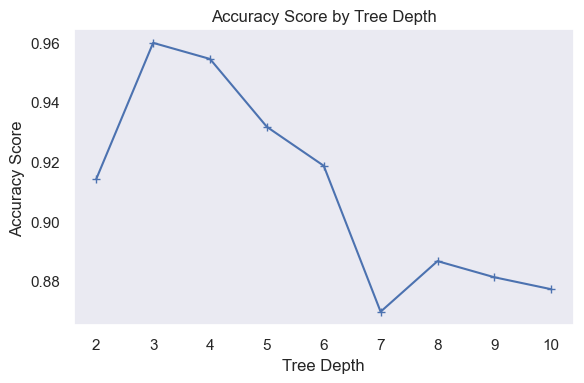

The best accuracy was 0.9598 with depth=3.


In [19]:
# defining maximum depth (try depth from 3 to 10)
n_min = 2
n_max = 11 
depth = np.zeros((n_max - n_min))

for i in range(n_min, n_max):
    tree = DecisionTreeClassifier(max_depth=i, criterion="entropy")
    tree.fit(X_rus, y_rus)
    y_pred_tree = tree.predict(X_val)

    depth[i-n_min] = accuracy_score(y_val, y_pred_tree)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(n_min, n_max), depth, marker="+")
ax.set_title('Accuracy Score by Tree Depth')
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Tree Depth')
ax.grid(False)

plt.tight_layout()
plt.show()

best_depth = depth.argmax() + n_min
print(f'The best accuracy was {round(depth.max(), 4)} with depth={best_depth}.') 



Classification report:
               precision    recall  f1-score   support

           0     0.9997    0.9593    0.9791     60417
           1     0.0349    0.8476    0.0671       105

    accuracy                         0.9591     60522
   macro avg     0.5173    0.9035    0.5231     60522
weighted avg     0.9981    0.9591    0.9775     60522

Accuracy: 0.9591
AUC: 0.9035



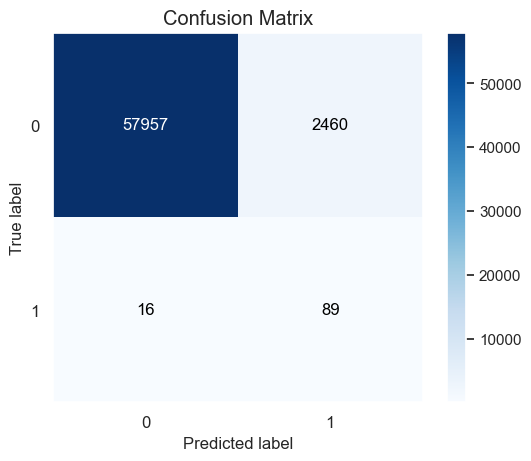

In [20]:
# defining and training the LR model
model_dt = DecisionTreeClassifier(max_depth=best_depth, criterion="entropy")
model_dt.fit(X_rus, y_rus)

# forecast using validation dataset
y_pred_dt = model_dt.predict(X_val)

# confusion matrix plot
skplt.metrics.plot_confusion_matrix(y_val, y_pred_dt)

# Classification report
print("Classification report:\n", classification_report(y_val, y_pred_dt, digits=4))

# Accuracy and area under the curve
print(f"Accuracy: {accuracy_score(y_val, y_pred_dt):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_pred_dt):.4f}\n")
plt.show()

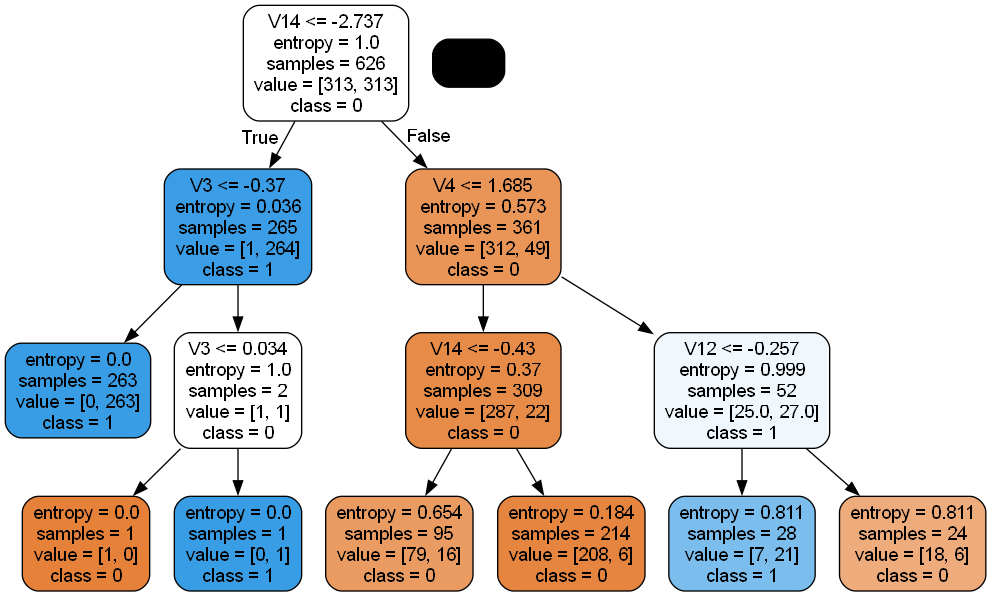

In [21]:
# criar DOT
dot = export_graphviz(model_dt, filled=True, rounded=True,
                      feature_names=X.columns, class_names=['0', '1'])

# plotar
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())

Using Decision Tree Model for this validation dataset, there are 60,417 valid transactions (57957 + 2460) and 105 fraudulent transactions (16 + 89).

Regarding the true values, among the total valid transactions, 57957 were correctly predicted (95.93%), while 2460 were incorrectly predicted as fraudulent (4.07%). For the fraudulent transactions, 89 were correctly predicted (84.76%) and 16 were incorrectly classified as valid (15.24%).

When looking at the predicted values, of the total predicted fraudulent transactions (89 + 2460 = 2549), 89 were correct (3.49%), and 2460 were incorrect (96.51%). For predicted valid transactions (57957 + 16 = 57973), 57957 were correct (99.97%), and 16 were incorrect (0.03%).

The model achieved an overall accuracy of 95.91%, indicating that 95.91% of all predictions, both fraud and non-fraud, were correct. Additionally, the AUC (Area Under the Curve) was 90.35%.

#### 3 - K-nearest Neighbors
Now, let's explore K-Nearest Neighbors (KNN), a powerful instance-based learning algorithm that classifies new data points based on their similarity to previously seen examples. In our credit card fraud detection scenario, this translates to identifying suspicious transactions by analyzing their proximity to known fraudulent and legitimate transactions.

Here's how KNN operates:

**1. A Matter of Proximity:**

Feature Space: Imagine each credit card transaction represented as a point in a multi-dimensional space, where each dimension corresponds to a feature (e.g., transaction amount, time, location).

Finding Neighbors: When classifying a new transaction, KNN locates the 'k' nearest neighbors to this point based on a chosen distance metric (e.g., Euclidean distance). In essence, it finds the 'k' most similar transactions in our dataset.

Majority Voting: The algorithm then assigns the class label that is most frequent among the 'k' nearest neighbors to the new transaction. For example, if a new transaction is surrounded by mostly fraudulent transactions in the feature space, it is likely to be classified as fraudulent as well.

**2. Why KNN fits our purpose:**

Simplicity: KNN is remarkably easy to understand and implement. It doesn't involve complex model training, making it a good starting point for classification tasks.

Non-linear Patterns: Similar to decision trees, KNN can effectively capture non-linear decision boundaries, allowing us to identify complex fraudulent patterns that linear models might miss.

Adaptability: KNN is a lazy learning algorithm, meaning it doesn't make assumptions about the underlying data distribution. This makes it adaptable to various datasets and less prone to bias from strong initial assumptions.

**3. Potential challenges:**

Computational Cost: As our dataset grows, finding the 'k' nearest neighbors for each new transaction can become computationally expensive. We might need to explore optimization techniques or consider alternative algorithms for very large datasets.

Curse of Dimensionality: In high-dimensional spaces (datasets with many features), the concept of distance becomes less meaningful, potentially affecting KNN's performance. Feature selection and dimensionality reduction techniques can help mitigate this challenge.

Sensitivity to 'k': Choosing the optimal value for 'k' (number of neighbors) is crucial. A small 'k' can make the model susceptible to noise, while a large 'k' might oversmooth the decision boundary.


In the following sections, we'll implement KNN for our credit card fraud detection project. 

c:\Users\hugom\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hugom\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


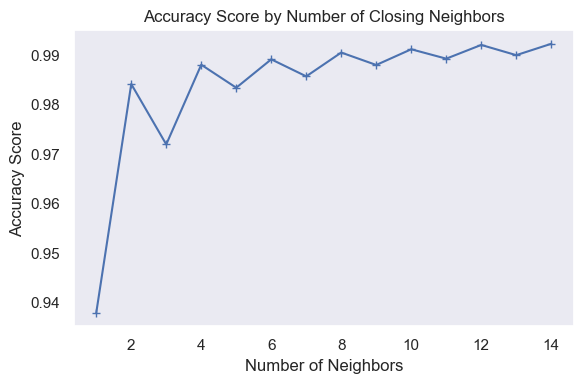

The best accuracy was 0.9923 with k=15.


In [22]:
# defining the number of closing neighbors
k_min = 1
k_max = 15
k_neighbors = np.zeros((k_max - k_min))

for i in range(k_min, k_max):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_rus, y_rus)
    y_pred_knn = knn.predict(X_val)

    k_neighbors[i - k_min] = accuracy_score(y_val, y_pred_knn)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(k_min, k_max), k_neighbors, marker="+")
ax.set_title('Accuracy Score by Number of Closing Neighbors')
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Number of Neighbors')
ax.grid(False)

plt.tight_layout()
plt.show()

best_k = k_neighbors.argmax() + n_min
print(f'The best accuracy was {round(k_neighbors.max(), 4)} with k={best_k}.') 

Classification report:
               precision    recall  f1-score   support

           0     0.9997    0.9916    0.9956     60417
           1     0.1472    0.8381    0.2504       105

    accuracy                         0.9913     60522
   macro avg     0.5734    0.9148    0.6230     60522
weighted avg     0.9982    0.9913    0.9943     60522

Accuracy: 0.9913
AUC: 0.9148



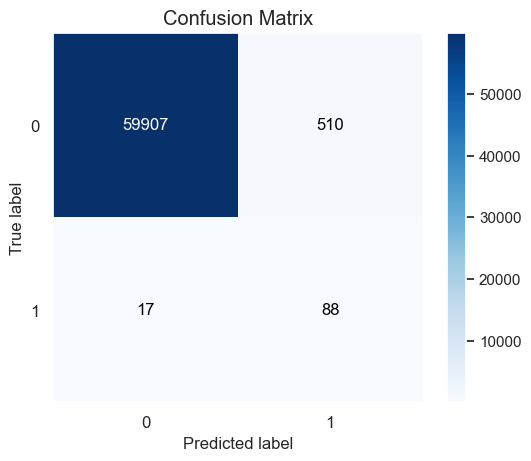

In [23]:
# defining and training the KNN model
model_knn = KNeighborsClassifier(n_neighbors=best_k)
model_knn.fit(X_rus, y_rus)

# model prediction
y_pred_knn = model_knn.predict(X_val)

# confusion matrix plot
skplt.metrics.plot_confusion_matrix(y_val, y_pred_knn)

# Classification report
print("Classification report:\n", classification_report(y_val, y_pred_knn, digits=4))

# Accuracy and area under the curve
print(f"Accuracy: {accuracy_score(y_val, y_pred_knn):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_pred_knn):.4f}\n")
plt.show()

Using KNN model for this validation dataset, there are 60,417 valid transactions (59907 + 507) and 105 fraudulent transactions (17 + 88).

Regarding the true values, among the total valid transactions, 59907 were correctly predicted (99.16%), while 507 were incorrectly predicted as fraudulent (0.84%). For the fraudulent transactions, 88 were correctly predicted (83.81%) and 17 were incorrectly classified as valid (16.19%).

When looking at the predicted values, of the total predicted fraudulent transactions (88 + 510 = 598), 88 were correct (14.72%), and 510 were incorrect (85.28%). For predicted valid transactions (59907 + 17 = 59924), 59907 were correct (99.97%), and 17 were incorrect (0.03%).

The model achieved an overall accuracy of 99.17%, indicating that 99.13% of all predictions, both fraud and non-fraud, were correct. Additionally, the AUC (Area Under the Curve) was 91.48%.

#### 4 - Random Forest Classifier
Taking the power of decision trees to the next level, we introduce Random Forest, an ensemble learning method that leverages the wisdom of multiple decision trees to create a highly accurate and robust fraud detection system. Imagine it as a council of experts, each with a slightly different perspective, coming together to make a collective and more reliable decision.

Here's how this "forest" works:

**1. Planting Trees with Randomness:**

Bootstrapping: Instead of relying on a single decision tree trained on the entire dataset, Random Forest creates multiple trees, each trained on a different random subset of the data. This process, known as bootstrapping, introduces diversity and reduces overfitting.

Feature Randomness: To further enhance diversity, each tree only considers a random subset of features when splitting nodes. This prevents dominant features from overshadowing others and encourages the exploration of different decision paths.

**2. The Power of the Collective:**

Independent Decisions: Each tree in the forest processes the incoming transaction data and makes an independent prediction (fraudulent or legitimate).

Majority Voting: The final classification is determined through a majority voting scheme. The class label that receives the most votes from individual trees becomes the overall prediction of the Random Forest.

**3. Why Random Forest stands strong:**

High Accuracy: By combining multiple decision trees, Random Forest reduces variance and improves prediction accuracy, often surpassing the performance of individual trees.

Robustness: It's less susceptible to outliers and noise in the data, as errors made by individual trees are often outweighed by the correct predictions of the majority.

Feature Importance: Like individual decision trees, Random Forest provides insights into feature importance, allowing us to identify the most significant factors driving fraudulent activity.

**4. Considerations:**

Interpretability: While still interpretable to some extent, Random Forests are less transparent than individual decision trees due to the involvement of multiple trees.

Computational Cost: Training multiple trees requires more computational resources compared to a single tree. However, this is often a worthwhile trade-off for improved accuracy and robustness.

Now we'll implement a Random Forest model for our credit card fraud detection project. We'll then evaluate its performance, comparing it to our previous models, and analyze its ability to accurately and effectively distinguish between fraudulent and legitimate transactions.

Classification report:
               precision    recall  f1-score   support

           0     0.9998    0.9804    0.9900     60417
           1     0.0720    0.8762    0.1330       105

    accuracy                         0.9802     60522
   macro avg     0.5359    0.9283    0.5615     60522
weighted avg     0.9982    0.9802    0.9885     60522

Accuracy: 0.9802
AUC: 0.9283



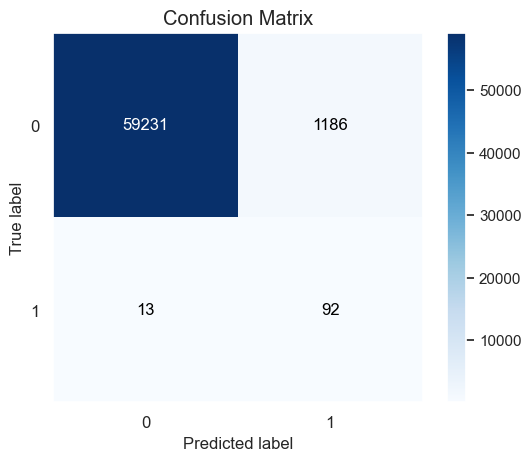

In [27]:
# defining and training the RandomForest Model
model_rfc = RandomForestClassifier(n_estimators=300)
model_rfc.fit(X_rus, y_rus)

# model prediction
y_pred_rfc = model_rfc.predict(X_val)

# confusion matrix plot
skplt.metrics.plot_confusion_matrix(y_val, y_pred_rfc)

# Classification report
print("Classification report:\n", classification_report(y_val, y_pred_rfc, digits=4))

# Accuracy and area under the curve
print(f"Accuracy: {accuracy_score(y_val, y_pred_rfc):.4f}")
print(f"AUC: {roc_auc_score(y_val, y_pred_rfc):.4f}\n")
plt.show()

The Confusion Matrix provides a clear view of the model’s performance by comparing true values with predicted values. In this validation dataset, there are 60,417 valid transactions (59231 + 1186) and 105 fraudulent transactions (13 + 92).

Regarding the true values, among the total valid transactions, 59231 were correctly predicted (98.04%), while 1186 were incorrectly predicted as fraudulent (1.96%). For the fraudulent transactions, 92 were correctly predicted (87.62%) and 13 were incorrectly classified as valid (12.38%).

When looking at the predicted values, of the total predicted fraudulent transactions (92 + 1186 = 1278), 92 were correct (7.20%), and 1186 were incorrect (92.80%). For predicted valid transactions (59231 + 13 = 59244), 59231 were correct (99.98%), and 13 were incorrect (0.02%).

The model achieved an overall accuracy of 98.02%, indicating that 98.02% of all predictions, both fraud and non-fraud, were correct. Additionally, the AUC (Area Under the Curve) was 92.83%.

#### 5 - Selected Model
Each evaluated model has its own advantages and disadvantages. The selected model should be the one that best addresses our specific problem. While the KNN model had the highest overall accuracy, we are particularly focused on the model’s ability to accurately predict fraudulent transactions. The Logistic Regression model performed best in this regard, correctly predicting 95 out of 105 fraudulent transactions and misclassifying only 10.

Therefore, we will use the Logistic Regression model to predict the transaction classes on the test dataset.

Classification report:
               precision    recall  f1-score   support

           0     0.9999    0.9726    0.9860     42647
           1     0.0557    0.9324    0.1052        74

    accuracy                         0.9725     42721
   macro avg     0.5278    0.9525    0.5456     42721
weighted avg     0.9982    0.9725    0.9845     42721

Accuracy: 0.9725
AUC: 0.9525



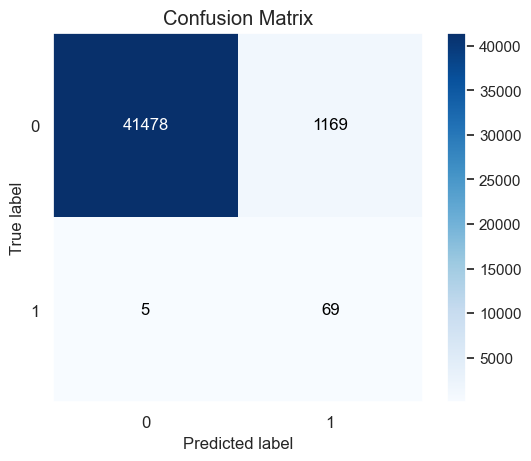

In [31]:
# split the dataset into feature and target
X_test = test.drop("Class", axis=1)
y_test = test["Class"]

# prediction
y_pred = model_lr.predict(X_test)

# confusion matrix plot
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

# Classification report
print("Classification report:\n", classification_report(y_test, y_pred, digits=4))

# Accuracy and area under the curve
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}\n")
plt.show()



### Conclusion
Among all the evaluated models, the Logistic Regression model demonstrated the best performance for this task.

When applied to the test dataset, the selected model (Logistic Regression) produced results similar to those on the validation dataset. The overall accuracy was 97.25%. The model correctly predicted 93.24% of the fraudulent transactions, meaning that out of 74 fraudulent transactions, 69 were correctly classified. For valid transactions, the model achieved a 97.26% accuracy, correctly predicting 41,478 out of 42,647 valid transactions.